DEBUG: Found 3065 .mat files.
DEBUG: Loaded 3064 final images.
Data preprocessed for MobileNetV2.
Data split: Train=2144, Val=460, Test=460
Model compiled.

Starting model training...
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4923 - loss: 1.0818
Epoch 1: val_accuracy improved from -inf to 0.30217, saving model to mobilenetv2_scratch_figshare.h5
67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 187ms/step - accuracy: 0.4933 - loss: 1.0800 - val_accuracy: 0.3022 - val_loss: 1.0991
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6524 - loss: 0.7988
Epoch 2: val_accuracy did not improve from 0.30217
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6526 - loss: 0.7983 - val_accuracy: 0.3022 - val_loss: 1.1005
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7009 - loss: 0.6323
Epoch 3: val_accuracy did not improve from 0.30217
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.7012 - loss: 0.6322 - val_accuracy: 0.3022 - val_loss: 1.1031
Epoch 4/

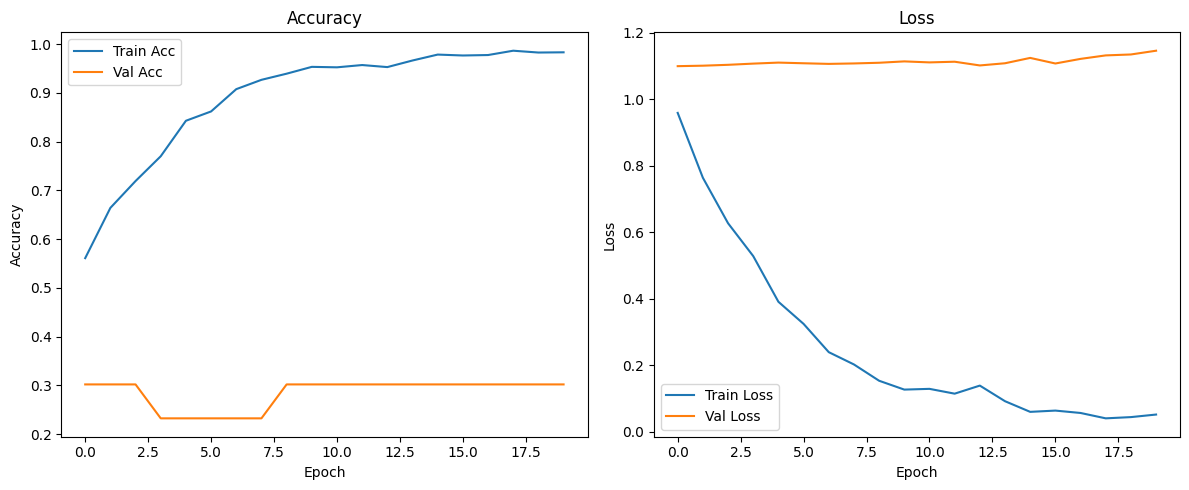


Evaluating on Test Set...
✅ Test Accuracy: 0.3043
📉 Test Loss: 1.0990
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.00      0.00      0.00       214
           2       0.30      1.00      0.47       140

    accuracy                           0.30       460
   macro avg       0.10      0.33      0.16       460
weighted avg       0.09      0.30      0.14       460


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


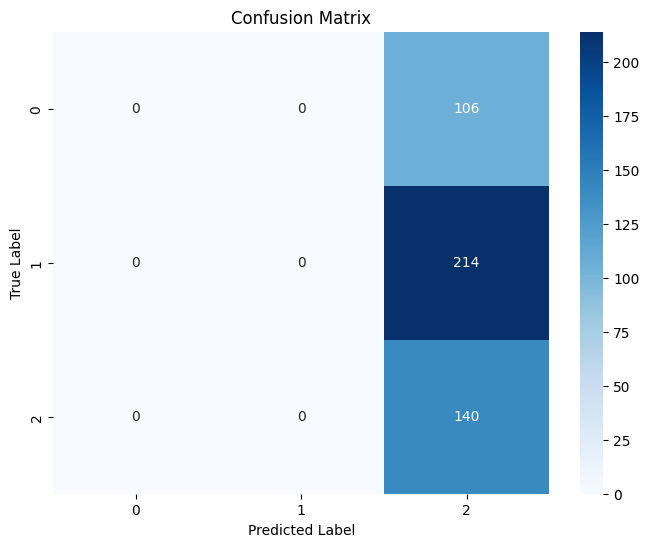

In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import h5py 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
# 🛠️ Change DenseNet121 imports to MobileNetV2 imports
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

# ======================
# ⚙️ Parameters
# ======================
dataset_dir = "/kaggle/input/figshare-datset" 
IMG_SIZE = (224, 224)
EPOCHS = 20
BATCH_SIZE = 32
MODEL_NAME = "mobilenetv2_scratch_figshare.h5" # New model filename

# ======================
# 🧩 Step 1: Load .mat files (Robust for v7.3 HDF5 and v7.2 scipy)
# ======================
mat_files = glob.glob(os.path.join(dataset_dir, "**", "*.mat"), recursive=True)
print(f"DEBUG: Found {len(mat_files)} .mat files.")

if len(mat_files) == 0:
    print("🛑 FATAL ERROR: No .mat files found. Please check your 'dataset_dir' path.")
    raise FileNotFoundError("Cannot proceed without data. Check 'dataset_dir' path.")

images, labels = [], []
file_count = 0

for file in mat_files:
    file_count += 1
    # 🌟 Initialize img and label at the start of the loop
    img = None
    label = None
    
    # --- Data Loading Logic ---
    # 1. Try h5py for MATLAB v7.3 (HDF5) files
    try:
        with h5py.File(file, 'r') as f:
            if 'cjdata' in f:
                img_data = f['cjdata']
                img = np.array(img_data['image'])
                # Labels often stored as a 1x1 array in h5py, flatten to scalar
                label = int(np.array(img_data['label']).flat[0])
            
    except Exception: # Catch HDF5/cjdata structure failure
        
        # 2. Try scipy.io.loadmat for older MATLAB formats (v5, v7.2)
        try:
            data = loadmat(file)
            
            # Use original extraction logic for scipy data structure
            if 'cjdata' in data:
                img_data = data['cjdata'][0,0]
                img = img_data['image']
                label = int(img_data['label'].flat[0])
            elif 'image' in data and 'label' in data:
                img = data['image']
                label = int(data['label'].flat[0])
            
        except Exception as e_scipy:
             continue


    # --- Processing Logic (after successful load) ---
    if img is not None and label is not None:
        
        # Convert grayscale (2D) to 3-channel (RGB)
        if img.ndim == 2:
            img = np.stack((img,)*3, axis=-1)
        
        # Resize to the target size (required to be 224x224 for MobileNetV2)
        img = np.array(tf.image.resize(img, IMG_SIZE))
        
        images.append(img)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

print(f"DEBUG: Loaded {X.shape[0]} final images.") 

if X.shape[0] == 0:
    print("🛑 FATAL ERROR: X is empty after loading. Extraction failed.")
    raise ValueError("X is empty. Data loading failed.")

# ======================
# 🧪 Step 2: Prepare data
# ======================
# 🛠️ Use MobileNetV2 specific preprocessing
X = preprocess_input(X)
print("Data preprocessed for MobileNetV2.")

NUM_CLASSES = len(np.unique(y))
y = to_categorical(y - 1, NUM_CLASSES)  

# ======================
# 🔄 Step 3: Train-test split
# ======================
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"Data split: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")

# ======================
# 🔧 Step 4: Model (MobileNetV2 Architecture)
# ======================
# 🛠️ Change base model to MobileNetV2
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("Model compiled.")

# ======================
# 🏋️ Step 5: Train
# ======================
# 🛠️ Update checkpoint filename
checkpoint = ModelCheckpoint(MODEL_NAME, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

print("\nStarting model training...")

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpoint, earlystop])

# ======================
# 📈 Step 6: Plot accuracy/loss
# ======================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ======================
# 🧪 Step 7: Evaluate
# ======================
print("\nEvaluating on Test Set...")
try:
    # 🛠️ Load the new model weights
    model.load_weights(MODEL_NAME)
except Exception:
    pass 

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"📉 Test Loss: {loss:.4f}")

# Optional: Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(NUM_CLASSES)]))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(NUM_CLASSES)], 
            yticklabels=[str(i) for i in range(NUM_CLASSES)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()